In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib.util
import sys
file_path = "../Tehtava-03/preprocessor.py"; module_name = "preprocessor"; spec = importlib.util.spec_from_file_location(module_name, file_path)
esik = importlib.util.module_from_spec(spec); sys.modules[module_name] = esik; spec.loader.exec_module(esik)


cols = ['total_installed_price', 'system_size_DC', 'price_per_kW', 'battery_rated_capacity_kW', 'battery_rated_capacity_kWh', 
        'installer_name', 'customer_segment', 'expansion_system']
cols.extend(esik.cf.solar_storage_hybrid_inverter)
#cols = cf.all_orig()

# minimal valinnalla esikäsittely on kaikkein vähäisin
df_all = esik.esik(cols, mode='minimal')

In [2]:
# FormatterFunc
def no_mult(x, pos):
    """The two arguments are the value and tick position."""
    return '{:1.0f}'.format(x)

def kilo(x, pos):
    """The two arguments are the value and tick position."""
    return '{:1.1f}k'.format(x*1e-3)

## Hintajakauma järjestelmille, joissa on akkuvarasto

Tulkinnan mukaan järjestelmässä on akku, jos:

- akun teho on ilmoitettu `battery_rated_capacity_kW`
- akun kapasiteetti on ilmoitettu `battery_rated_capacity_kW`
- järjestelmässä on `solar_storage_hybrid_inverter`

`expansion_system` suodatus testattu, jotta voidaan eritellä jälkeenpäin tehdyt akkuasennukset (joissa ehkä usein mukana myös paneeliasennuksia).

df.shape (16855, 11)
df.shape (15449, 11)


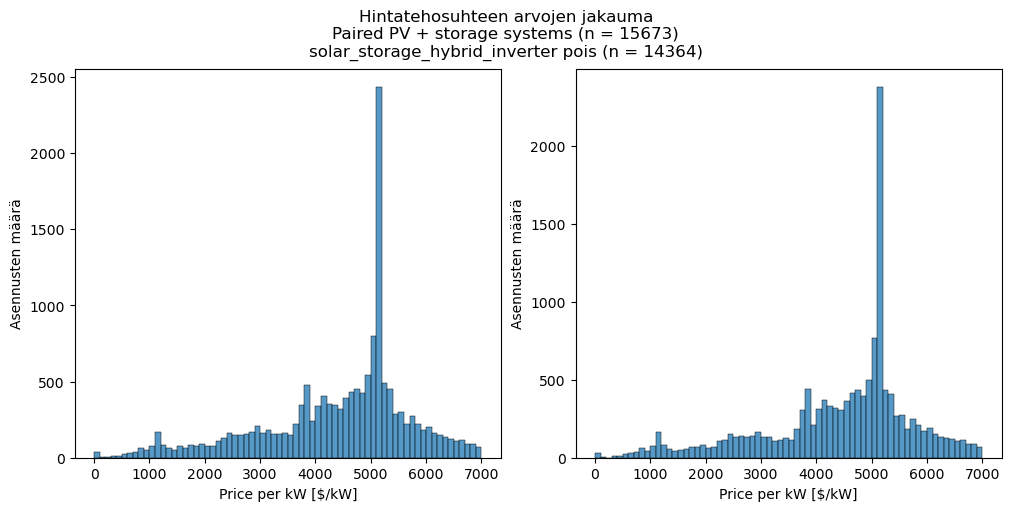

In [3]:
df = df_all.copy()
df['battery_rated_capacity_kW'] = df['battery_rated_capacity_kW'].notna()
df['battery_rated_capacity_kWh'] = df['battery_rated_capacity_kWh'].notna()
df_1 = df[(df[esik.cf.solar_storage_hybrid_inverter[0]] == 1)]
df_2 = df[(df[esik.cf.solar_storage_hybrid_inverter[1]] == 1)]
df_3 = df[(df[esik.cf.solar_storage_hybrid_inverter[2]] == 1)]
df_4 = df[(df['battery_rated_capacity_kW'] == True)]
df_5 = df[(df['battery_rated_capacity_kWh'] == True)]
df = pd.concat([df_1, df_2, df_3, df_4, df_5])
#df = pd.concat([df_4, df_5])
# Karsitaan useamman ehdon täyttäneet rivit pois indeksin avulla
df['df_index'] = df.index
df.drop_duplicates(subset=['df_index'], inplace=True)
df.drop('df_index', axis=1, inplace=True)
print("df.shape", df.shape)

binwidth = 100
max_1 = 7000

# Datan rajaus
df_1 = df[(df['price_per_kW'] < max_1)]
count_1 = df_1['price_per_kW'].count()

# solar_storage_hybrid_inverter poistettu kriteereistä
df = df_all.copy()
df['battery_rated_capacity_kW'] = df['battery_rated_capacity_kW'].notna()
df['battery_rated_capacity_kWh'] = df['battery_rated_capacity_kWh'].notna()
df_4 = df[(df['battery_rated_capacity_kW'] == True)]
df_5 = df[(df['battery_rated_capacity_kWh'] == True)]
df = pd.concat([df_4, df_5])
# Karsitaan useamman ehdon täyttäneet rivit pois indeksin avulla
df['df_index'] = df.index
df.drop_duplicates(subset=['df_index'], inplace=True)
df.drop('df_index', axis=1, inplace=True)
print("df.shape", df.shape)

# Datan rajaus
df_2 = df[(df['price_per_kW'] < max_1)]
count_2 = df_2['price_per_kW'].count()

#Piirto
size_mult = 5
fig_rows = 1
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, layout="constrained", figsize=((fig_cols*size_mult),(fig_rows*size_mult)))

sns.histplot(data=df_1, x='price_per_kW', ax=axs[0], binwidth=binwidth)
axs[0].set_xlabel('Price per kW [$/kW]')
axs[0].set_ylabel('Asennusten määrä')
axs[0].xaxis.set_major_formatter(no_mult)

sns.histplot(data=df_2, x='price_per_kW', ax=axs[1], binwidth=binwidth)
axs[1].set_xlabel('Price per kW [$/kW]')
axs[1].set_ylabel('Asennusten määrä')
axs[1].xaxis.set_major_formatter(no_mult)

title = f'''Hintatehosuhteen arvojen jakauma
Paired PV + storage systems (n = {str(count_1)})
solar_storage_hybrid_inverter pois (n = {str(count_2)})'''

fig.suptitle(title)
plt.show()

Huomataan, että piikki osuu välille 5100-5200 $/kW, eli samaan kohtaan kuin muissa kuvaajissa.

## Tesla Energy

Lisää tarkastelua asentajan 'Tesla Energy' mukaan.

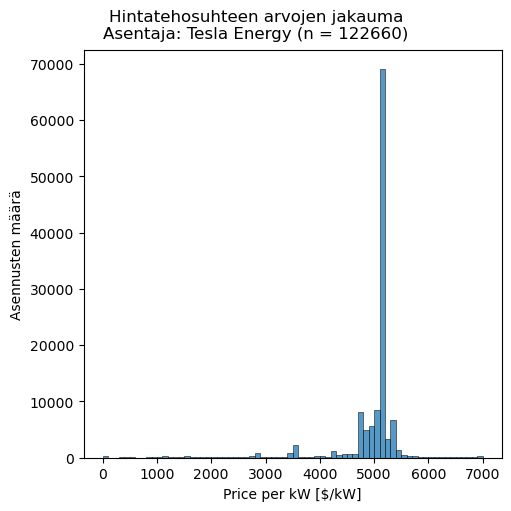

In [4]:
df = df_all.copy()
df = df[(df['installer_name'] == 'Tesla Energy')]

binwidth = 100
max_1 = 7000

# Datan rajaus
df_1 = df[(df['price_per_kW'] < max_1)]
count_1 = df_1['price_per_kW'].count()

#Piirto
size_mult = 5
fig_rows = 1
fig_cols = 1
fig, axs = plt.subplots(fig_rows, fig_cols, layout="constrained", figsize=((fig_cols*size_mult),(fig_rows*size_mult)))

sns.histplot(data=df_1, x='price_per_kW', ax=axs, binwidth=binwidth)
axs.set_xlabel('Price per kW [$/kW]')
axs.set_ylabel('Asennusten määrä')
axs.xaxis.set_major_formatter(no_mult)

title = f'''Hintatehosuhteen arvojen jakauma
Asentaja: Tesla Energy (n = {str(count_1)})'''

fig.suptitle(title)
plt.show()

Voidaan olettaa, että piikki johtuu 'Tesla Energy':n poikkeuksellisesta tavasta hinnoitella järjestelmäasennukset hintatehosuhteen mukaan. Voidaan kai olettaa, että lähes kaikki 5100-5200 $/kW Teslan järjestelmistä sisältää samankaltaisen hinnoittelun perusteella akun, mutta niistä on vain vähän merkkejä datassa.

Vai pitäisikö tehdä oletus, että kaikki Teslan järjestelmät sisältävät akun?

## Retrofit?

In [5]:
#df.dropna(subset=['system_size_DC'], inplace=True)
df.groupby(['expansion_system', 'customer_segment']).agg({'total_installed_price': ['size', 'count', 'min', 'median', 'mean', 'max'], 'price_per_kW': ['count', 'min', 'max']})

total_installed_price                     \
                                                   size   count        min   
expansion_system customer_segment                                            
0                COM                               1031     619       1.00   
                 GOV                               1037    1033       1.00   
                 NON-PROFIT                          52      52       1.00   
                 RES                             166329  126731       0.01   
                 SCHOOL                             132     126       1.00   
1                COM                                  9       4   46080.00   
                 GOV                                  1       1  873556.00   
                 RES                               1517    1289    2292.80   
                 SCHOOL                               2       2   98604.17   

                                                                         \
                                        median          mean        max   
expansion_system customer_segment                                         
0                COM                209223.000  6.548376e+05  7789680.0   
                 GOV                 13884.000  2.525991e+05  4739290.0   
                 NON-PROFIT         186151.900  5.640209e+05  7062552.0   
                 RES                 26268.000  2.926541e+04  2271734.0   
                 SCHOOL             234030.500  2.896159e+05  1235412.0   
1                COM               1407057.000  1.225380e+06  2041328.0   
                 GOV                873556.000  8.735560e+05   873556.0   
                 RES                 20352.000  2.396045e+04   159962.0   
                 SCHOOL             363136.585  3.631366e+05   627669.0   

                                  price_per_kW                              
                                         count          min            max  
expansion_system customer_segment                                           
0                COM                       619     0.007792   17342.998366  
                 GOV                      1033     0.000902   14728.955723  
                 NON-PROFIT                 52     0.109290   10830.000000  
                 RES                    126730     0.002220  385914.814815  
                 SCHOOL                    126     0.006378    8165.384615  
1                COM                         4  1107.000216    5120.000000  
                 GOV                         1  3537.236799    3537.236799  
                 RES                      1289   464.129555   40960.784314  
                 SCHOOL                      2  1072.938462    1108.285602

Pitäisikö 'expansion_system' suodattaa pois, jos vertaillaan asennuksia, jotta alkuperäisen asennuksen laitteet eivät tekisi laajennuksen osuudesta vaikeasti verrattavia?

## Stand alone PV

Vertailun vuoksi.

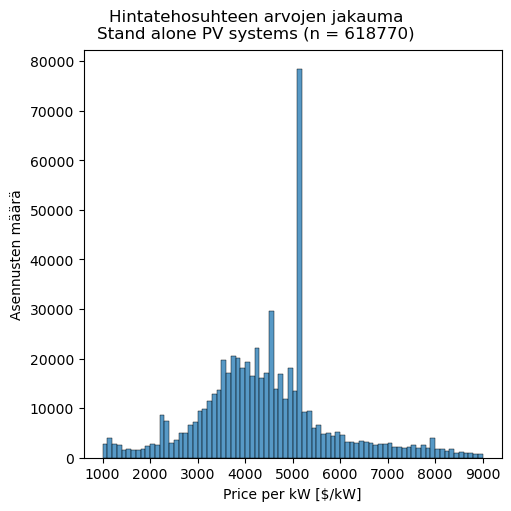

In [6]:
cols = ['price_per_kW', 'battery_storage']
df = esik.esik(cols)
df = df[(df['battery_storage'] == 0)]

binwidth = 100
max_1 = 9000

# Datan rajaus
df_1 = df[(df['price_per_kW'] < max_1)]
count_1 = df_1['price_per_kW'].count()

#Piirto
size_mult = 5
fig_rows = 1
fig_cols = 1
fig, axs = plt.subplots(fig_rows, fig_cols, layout="constrained", figsize=((fig_cols*size_mult),(fig_rows*size_mult)))

sns.histplot(data=df_1, x='price_per_kW', ax=axs, binwidth=binwidth)
axs.set_xlabel('Price per kW [$/kW]')
axs.set_ylabel('Asennusten määrä')
axs.xaxis.set_major_formatter(no_mult)

title = f'''Hintatehosuhteen arvojen jakauma
Stand alone PV systems (n = {str(count_1)})'''

fig.suptitle(title)
plt.show()

In [7]:
df = df_all.copy()
df['battery_rated_capacity_kW'] = df['battery_rated_capacity_kW'].notna()
df['battery_rated_capacity_kWh'] = df['battery_rated_capacity_kWh'].notna()
df_1 = df[(df[esik.cf.solar_storage_hybrid_inverter[0]] == 1)]
df_2 = df[(df[esik.cf.solar_storage_hybrid_inverter[1]] == 1)]
df_3 = df[(df[esik.cf.solar_storage_hybrid_inverter[2]] == 1)]
df_4 = df[(df['battery_rated_capacity_kW'] == True)]
df_5 = df[(df['battery_rated_capacity_kWh'] == True)]
df = pd.concat([df_1, df_2, df_3, df_4, df_5])
# Karsitaan useamman ehdon täyttäneet rivit pois indeksin avulla
df['df_index'] = df.index
df.drop_duplicates(subset=['df_index'], inplace=True)
df.drop('df_index', axis=1, inplace=True)
print("df.shape", df.shape)

df = df_all.copy()
df['battery_rated_capacity_kW'] = df['battery_rated_capacity_kW'].notna()
df['battery_rated_capacity_kWh'] = df['battery_rated_capacity_kWh'].notna()
df_4 = df[(df['battery_rated_capacity_kW'] == True)]
df_5 = df[(df['battery_rated_capacity_kWh'] == True)]
df = pd.concat([df_4, df_5])
# Karsitaan useamman ehdon täyttäneet rivit pois indeksin avulla
df['df_index'] = df.index
df.drop_duplicates(subset=['df_index'], inplace=True)
df.drop('df_index', axis=1, inplace=True)
print("df.shape", df.shape)

df = df_all.copy()
df_1 = df[(df[esik.cf.solar_storage_hybrid_inverter[0]] == 1)]
df_2 = df[(df[esik.cf.solar_storage_hybrid_inverter[1]] == 1)]
df_3 = df[(df[esik.cf.solar_storage_hybrid_inverter[2]] == 1)]
df = pd.concat([df_1, df_2, df_3])
# Karsitaan useamman ehdon täyttäneet rivit pois indeksin avulla
df['df_index'] = df.index
df.drop_duplicates(subset=['df_index'], inplace=True)
df.drop('df_index', axis=1, inplace=True)
print("df.shape", df.shape)


df.shape (16855, 11)
df.shape (15449, 11)
df.shape (3487, 11)


In [8]:
cols = ['battery_storage']

df = esik.esik(cols, tesla_battery='all', sshi_with_battery=True)
df = df[(df['battery_storage'] == 1)]
print("df.shape", df.shape)

df = esik.esik(cols, tesla_battery='all', sshi_with_battery=False)
df = df[(df['battery_storage'] == 1)]
print("df.shape", df.shape)

df = esik.esik(cols, tesla_battery='neutral', sshi_with_battery=True)
df = df[(df['battery_storage'] == 1)]
print("df.shape", df.shape)

df = esik.esik(cols, tesla_battery='neutral', sshi_with_battery=False)
df = df[(df['battery_storage'] == 1)]
print("df.shape", df.shape)

df = esik.esik(cols, tesla_battery='none', sshi_with_battery=True)
df = df[(df['battery_storage'] == 1)]
print("df.shape", df.shape)

df = esik.esik(cols, tesla_battery='none', sshi_with_battery=False)
df = df[(df['battery_storage'] == 1)]
print("df.shape", df.shape)


df.shape (182157, 1)
df.shape (180785, 1)
df.shape (16855, 1)
df.shape (15449, 1)
df.shape (12047, 1)
df.shape (10675, 1)


## Lisää Teslaa

Vuosi 2018, hintavertailua.

df.shape (14298, 4)


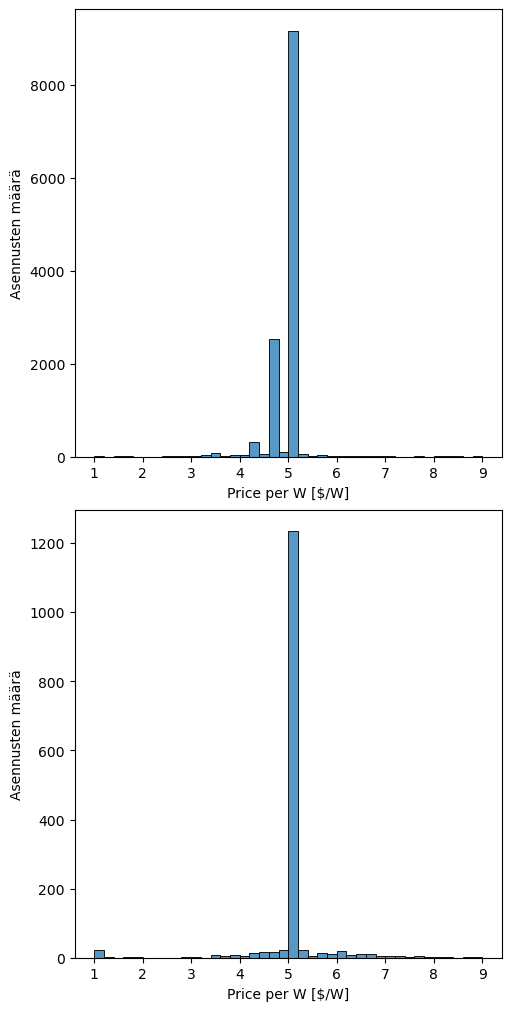

In [9]:
price_col = 'price_per_W'
cols = ['installer_name', price_col, 'battery_storage', 'year']

df = esik.esik(cols, tesla_battery='neutral', sshi_with_battery=False)
df = df[(df['year'] == 2018)]
df = df[(df['installer_name'] == 'Tesla Energy')]
df = df[(df[price_col] < 9)]
print("df.shape", df.shape)

binwidth = .2
df_1 = df[(df['battery_storage'] == 0)]
df_2 = df[(df['battery_storage'] == 1)]

#Piirto
size_mult = 5
fig_rows = 2
fig_cols = 1
fig, axs = plt.subplots(fig_rows, fig_cols, layout="constrained", figsize=((fig_cols*size_mult),(fig_rows*size_mult)))

sns.histplot(data=df_1, x=price_col, ax=axs[0], binwidth=binwidth)
axs[0].set_xlabel('Price per W [$/W]')
axs[0].set_ylabel('Asennusten määrä')
axs[0].xaxis.set_major_formatter(no_mult)

sns.histplot(data=df_2, x=price_col, ax=axs[1], binwidth=binwidth)
axs[1].set_xlabel('Price per W [$/W]')
axs[1].set_ylabel('Asennusten määrä')
axs[1].xaxis.set_major_formatter(no_mult)

#title = f'''Hintatehosuhteen arvojen jakauma Paired PV + storage systems (n = {str(count_1)}) solar_storage_hybrid_inverter pois (n = {str(count_2)})'''

#fig.suptitle(title)
plt.show()